A tutorial to upload a raw mat file of GPR data and reconstruct an image using XTFM algorithm. 

In [1]:
#@title #<font color='yellow'>Import required libraries</font> { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from google.colab import drive
import time
from scipy.io import loadmat

You can upload the file directly here in colab by tunning the cell below.

If this is slow, you can upload the file to your google drive, uncomment the line ```drive.mount(drive.mount('/content/drive')```, comment the line ```uploaded = files.upload()``` and change the value of the variabe ```path``` to the address where you uploaded the file. The file will show up on the left panel when you mount your google the drive. 

In [2]:
#@title #<font color='yellow'>Upload your GSSI raw mat file</font> { display-mode: "form" }
uploaded = files.upload()
#drive.mount('/content/drive')
path = list(uploaded.keys())[0]

Saving specimen_3.mat to specimen_3.mat


data size: (510, 465)


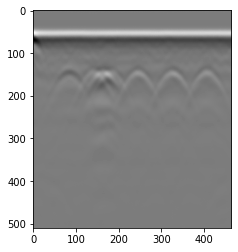

In [3]:
#@title #<font color='yellow'>Reading and plotting the raw file </font> { display-mode: "form" }

data = loadmat(path)
data= data[list(data.keys())[-1]]
print('data size:', data.shape)
plt.imshow(data, cmap = 'gray')
plt.show()

In [4]:
#@title #<font color='yellow'>XTFM function</font> { display-mode: "form" }
def XTFM(X, V, eps, sR, d, s, r, dim):
  '''
  X: 4D matrix of raw measurements containing all slices of independent and interelement
  data with the format of nS* sL * nC * nC , where nS is the number of independent scans,
  sL is the signal length of a raw measurement and nC is the number of channels of the instrument.
  v: velocity of the medium
  ε: time offset
  sR: signal resolution
  d: recording frequency
  s: transducer spacing
  r: desired resolution
  dim: grid dimensions (2D)
  Output: im (reconstructed image)
  '''

  # Initialize vectors, xn, yn spanning from 0 to dim *r with a step of r
  yn = np.arange(0,dim[0]*r,r).reshape(-1,1)
  xn = np.arange(0,dim[1]*r,r).reshape(-1,1) 

  # square yn once to save time in the main the loop
  yn_sq = (yn**2).reshape(1,-1) 
  # Initialize the output image, im, with zeros with a size of dim
  im = np.zeros((len(yn),len(xn)))

  # get sL, nS, and nC from X shape
  sL = X.shape[1]
  nS = X.shape[0]
  nC  = X.shape[2]

  # For every k independent measurement (total of nS) 
  for k in range(nS):
    # For every i, j interelement measurement (total of (nC * (nC-1)/2):
    for i in range(nC):
      for j in range(i+1,nC):
        # Calculate t matrix
        t = np.round((((np.sqrt((xn-i*s - k*d)**2+yn_sq))+(np.sqrt((xn-j*s-k*d)**2+yn_sq)))/V+eps)/sR)
        # Mask T matrix to discard out of range values (values bigger than sL) and add the correct signal to the image
        t[t>=sL] = -2
        t= t.astype(int).T
        im += np.ma.array(X[k,t, i, j], mask = t==-2) 
  return im

# Input parameters

Define the required parameters for XTFM image reconstruction

In [5]:
# Desired region of interest, 300 means: 300 hundered pixels with a resolution defined below
mesh_dim =[300,952] 
# transducer spacing, this is 1.6 inch for GSSI mini XT
spacing = 1.6;      
# recording frequency, it is 0.1 inch for GSSI mini XT
recording_step = 0.1;      
# signal resolution (This is 8.41ns signal duration for GSSI mini XT over the number of data points (512)
sR = 8.41 / 512   
 # Desired Resolution (Finer resolution = more processing time)
resolution = 0.05;    # (inch)  
# Assuming wave speed
v=4.2;      # (inch/ns)
# Assuming epsilon     
const = 0.9;   

Image reconstructed sucessfully in 2.032501220703125 seconds.


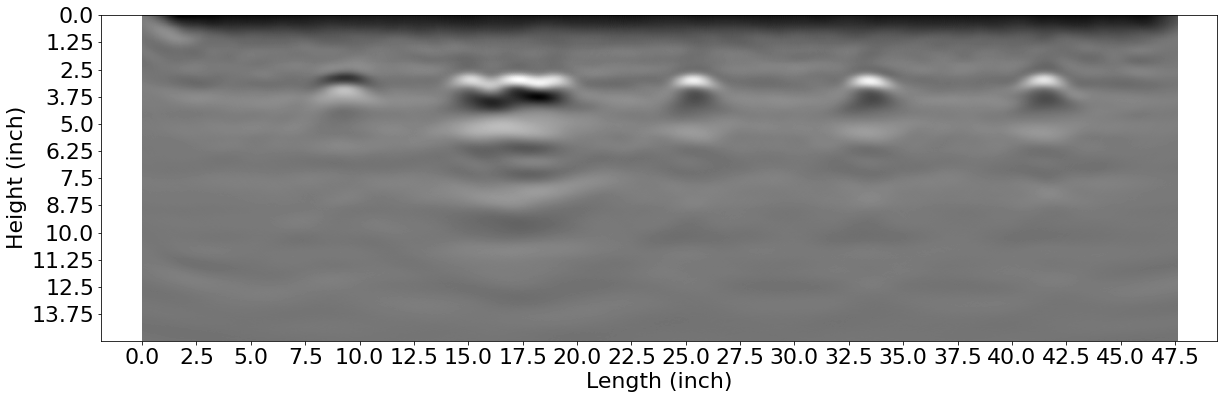

In [17]:
#@title #<font color='yellow'>Run XTFM </font> { display-mode: "form" }

# Change font size of matplotlib plots
plt.rcParams.update({'font.size': 22}) 

# Turn data into FMC format for XTFM
Y = np.zeros((data.shape[1], data.shape[0],2, 2))
Y[:, :, 0, 1] = data.T
Y[:, :, 1, 0] = data.T
# Measuring run time
t1 = time.time()
# Run XTFM
img = XTFM(Y, v, const, sR, recording_step, spacing, resolution ,mesh_dim)
t2 = time.time() - t1
print('Image reconstructed sucessfully in',t2,'seconds.')

# defining the figure and figure size
fig = plt.figure(figsize=(20, 6))
# Showing the image with desired colormap
plt.imshow(img, cmap= 'gray') 
# Setting plot axis labels and ticks
plt.xlabel('Length (inch)')
plt.ylabel('Height (inch)')
x_ticks = np.arange(0,mesh_dim[1]+1,50)
y_ticks = np.arange(0,mesh_dim[0]+1,25)
plt.yticks(y_ticks,np.round(y_ticks*resolution,2))
plt.xticks(x_ticks,np.round(x_ticks*resolution,2))
plt.axis('equal')
plt.show()